#  El Problema

Vamos a utilizar los datos de la competición de predicción de los datos del Dengue. Mas información en [enlace](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

El objetivo del ejercicio es por un lado jugar con una red neuronal para resolver un problema de regresión y por otro participar en una competición de datos. 


# Setting Preliminares

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

# Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

En primer lugar subimos los datos de entrenamiento sin campo objetivo (dengue_features_train)


In [ ]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train (2).csv
User uploaded file "dengue_features_train.csv" with length 266487 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,30/04/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,7/05/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,14/05/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,21/05/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,28/05/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
train_feat.shape

(1456, 24)

Posteriormente subimos los datos que únicamente nos proporcionan el número de casos de dengue para las semanas de entrenamiento (dengue_labels_train)

In [ ]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train (2).csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe, para nuestro analisis vamos a separar los datos en dos grupos el primer grupo train1 para la ciudad sj y el segundo grupo train2 para la ciudad iq 

In [ ]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
train1 = train[train['city']=='sj']
train2 = train[train['city']=='iq']
train1.head()
train2.head()


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
936,iq,2000,26,1/07/2000,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
937,iq,2000,27,8/07/2000,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
938,iq,2000,28,15/07/2000,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
939,iq,2000,29,22/07/2000,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
940,iq,2000,30,29/07/2000,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


Finalmente subimos los datos para generar la evaluación final (dengue_features_test) cuando estamos cargando los datos para nuestro test debemos nuevamente generar dos grupos por ciudades test1 para la ciudad sj y test2 para la ciudad iq

In [ ]:
test = upload_files()
test1= test[test['city']=='sj']
test2= test[test['city']=='iq']
test1.head()
test2.head()

Saving dengue_features_test.csv to dengue_features_test (2).csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,...,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0


In [ ]:
test1.shape, test2.shape

((260, 23), (156, 23))

# Preproceso

Aquí irían todas las funciones y transformaciones que permitieran el uso de las variables en los siguientes clasificadores, por ejemplo la transformación de las variables categóricas en numéricas, vamos a eliminar la caracteristica week_start_date ya que es un valor que es un valor que no lo necesitamos para nuestro analisis.

In [ ]:
train1.drop("week_start_date", axis = 1, inplace = True)
train2.drop("week_start_date", axis = 1, inplace = True)
test1.drop("week_start_date", axis = 1, inplace = True)
test2.drop("week_start_date", axis = 1, inplace = True)
train1.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Trataremos los valores perdidos que los hay dado que nos evitarían tener un modelo de los datos que tenemos, comprobamos cuantos valores nulos hay en cada una de las caracteristicas.

In [ ]:
pd.isnull(train1).sum()
pd.isnull(train2).sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm               

Los vamos a procesar de forma automática completandolos con el método ffill con el valor de la media

In [ ]:
# ffill: propagate last valid observation forward to next valid backfill
# Otra Opción: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
train1=train1.fillna(train1.mean())
pd.isnull(train1).any()
train2=train2.fillna(train2.mean())
pd.isnull(train1).any()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

Y aplicamos lo mismo para el test

In [ ]:
test1=test1.fillna(test1.mean())
pd.isnull(test1).any()
test2=test2.fillna(test2.mean())
pd.isnull(test2).any()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

También tenemos que transformar nuestras variables categóricas, en este caso una única variable que es la ciudad para lo que vamos a utilizar un *binarizador* para train y para test

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train1['city_bin'] = lb.fit_transform(train1['city'])
test1['city_bin'] = lb.fit_transform(test1['city'])
train2['city_bin'] = lb.fit_transform(train2['city'])
test2['city_bin'] = lb.fit_transform(test2['city'])

In [ ]:
train1.tail()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
931,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,...,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4,0
932,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,...,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3,0
933,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,...,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1,0
934,sj,2008,16,0.00180,0.067469,0.203900,0.209843,0.00,297.630000,297.778571,...,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3,0
935,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,...,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,5,0


Hay que seleccionar características, de acuerdo al desarrollo de la actividad 1 he seleccionado algunas de las caracteristicas mas influyentes en el dataset se muestran acontinuacion.

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']

Normalizamos los datos a partir de los coeficientes mínimo y máximo de la colección de entrenamiento como estamos trabajando dos modelos diferentes es necesario definir cada uno de estos para las dos ciudades.

**(Es opcional y no siempre efectivo)**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
X_train1 = scaler1.fit_transform(train1[selected_features])
X_test1 = scaler1.transform(test1[selected_features])
y_train1 = train1['total_cases']

X_train2 = scaler2.fit_transform(train2[selected_features])
X_test2 = scaler2.transform(test2[selected_features])
y_train2 = train2['total_cases']




# Construcción y evaluación preliminar del modelo

Para la construccion del modelo tenemos que tener en cuenta nuevamente como estamos trabajando nuestro dataset es decir dos modelos para la regresion lineal, En el MODELO LINEAL

In [ ]:
from sklearn import linear_model
model1 = linear_model.LinearRegression()
model2 = linear_model.LinearRegression()
model1.fit(X_train1, y_train1)
model2.fit(X_train2, y_train2)


LinearRegression()

# Generación del Resultado Final

Generamos el fichero de salida segun el Submission format
* Realizamos la predicción sobre el test para nuestros dos modelos

* Redondeamos el resultado de sj y iq por que el formato para la competencia se da solamente con valores enteros ya que en este contexto no tiene sentido predecir numeros con decimales




In [ ]:
#----Modelo Lineal
y_pred1 = model1.predict(X_test1)
y_pred2 = model2.predict(X_test2)

In [ ]:
# round the result and cast to int
import numpy as np
#-----Modelo lineal
y1 = np.rint(y_pred1) # round
y1 = y1.astype(int) # cast to int
res1 = np.hstack(y1)
res1
y2 = np.rint(y_pred2) # round
y2 = y2.astype(int) # cast to int
res2 = np.hstack(y2)
res2

array([ 8,  6,  9,  2,  2,  6,  5,  6,  6,  7,  7,  6,  6,  5,  5,  6,  7,
       10, 13,  8,  9, 11, 11, 12,  9,  6,  9,  8,  9,  9,  7,  7,  9,  9,
       10, 10,  9,  9, 10, 11, 10,  9,  9, 11, 11,  6,  9,  8,  6,  5,  7,
        4,  6,  6,  3,  5,  5,  5,  5,  5,  2,  2,  5,  7,  7,  9,  8,  9,
       12,  9,  8, 10, 10, 10, 10, 11, 10, 11, 11, 10,  9,  8,  8, 10, 11,
        9,  8,  7,  9,  8,  7,  9,  8, 11, 11,  9,  9,  5,  9,  6,  7,  6,
        4,  6,  5,  5,  5,  6,  3,  4,  3,  4,  5,  5,  4,  5,  4,  6,  4,
       10,  7, 12, 10,  9, 13, 14, 14, 10, 11, 12, 11,  7,  9, 11, 10, 12,
       10, 11,  9, 10, 11, 14, 12,  9,  9, 12,  9,  3, 11,  9,  8,  8,  8,
        6,  5,  6])

A continuacion vamos a garantizar que si alguna de nuestras predicciones ha sido negativa la omita en el proceso y cambie este valor por un cero, esto es para garantizar nuevamente que los datos que se han predecido sean validos.


In [ ]:
#-----Modelo Lineal
y_pred_no_neg1 = res1.copy()
y_pred_no_neg2 = res2.copy()

#-----Modelo Lineal
y_pred_no_neg1[y_pred1 < 0] = 0
y_pred_no_neg1
y_pred_no_neg2[y_pred2 < 0] = 0
y_pred_no_neg2

array([ 8,  6,  9,  2,  2,  6,  5,  6,  6,  7,  7,  6,  6,  5,  5,  6,  7,
       10, 13,  8,  9, 11, 11, 12,  9,  6,  9,  8,  9,  9,  7,  7,  9,  9,
       10, 10,  9,  9, 10, 11, 10,  9,  9, 11, 11,  6,  9,  8,  6,  5,  7,
        4,  6,  6,  3,  5,  5,  5,  5,  5,  2,  2,  5,  7,  7,  9,  8,  9,
       12,  9,  8, 10, 10, 10, 10, 11, 10, 11, 11, 10,  9,  8,  8, 10, 11,
        9,  8,  7,  9,  8,  7,  9,  8, 11, 11,  9,  9,  5,  9,  6,  7,  6,
        4,  6,  5,  5,  5,  6,  3,  4,  3,  4,  5,  5,  4,  5,  4,  6,  4,
       10,  7, 12, 10,  9, 13, 14, 14, 10, 11, 12, 11,  7,  9, 11, 10, 12,
       10, 11,  9, 10, 11, 14, 12,  9,  9, 12,  9,  3, 11,  9,  8,  8,  8,
        6,  5,  6])

* Generamos el fichero de salida, como tenemos que generar el archivo en cierto formato, he unido los dos dataframe con sus correspondientes valores predecidos en un nuevo dataframe y luego he genero el archivo csv que se subira a la pagina de la compentencia

In [ ]:
output1 = pd.DataFrame({ 'city': test1['city'], 'year': test1['year'], 'weekofyear': test1['weekofyear'], 
                       'total_cases': y_pred_no_neg1})

output2 = pd.DataFrame({ 'city': test2['city'], 'year': test2['year'], 'weekofyear': test2['weekofyear'], 
                       'total_cases': y_pred_no_neg2})

output= pd.concat([output1,output2], ignore_index=True)

In [ ]:
from google.colab import files

with open('resultadoModeloLineal.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('resultadoModeloLineal.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,28
1,sj,2008,19,25
2,sj,2008,20,34
3,sj,2008,21,28
4,sj,2008,22,30


Despues de validar nuestro resultado en la competencia hemos alcanzado el siguiente score de 25.8510 mi usuario en la competencia es JuanDuenez y al dia de hoy ocupo la posicion 1757.

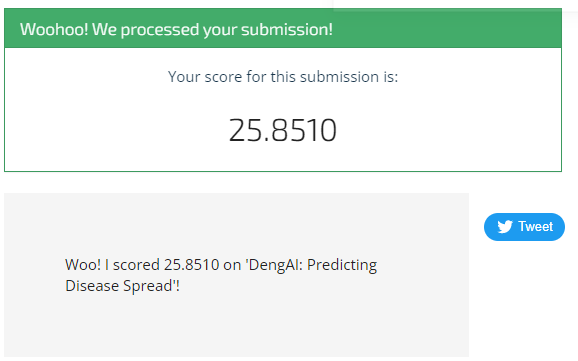